In [1]:
%load_ext nb_black
import warnings

warnings.filterwarnings("ignore")
import math
import sys
import datetime
from dateutil import parser
from scipy.optimize import curve_fit

sys.path.append("/Users/vikaspandey/my_projects/deeplearning_ai")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from utils.utils import load_data_from_csv_as_pd
from data_visualisation.bar_chart.bar import Bar
from scipy.optimize import curve_fit

base_url = "https://api.covid19india.org/csv/latest"

files = {
    "raw_data": {"cols_to_be_renamed": {}},
    "state_wise": {
        "cols_to_be_renamed": {
            "State": "state",
            "Confirmed": "confirmed",
            "Recovered": "recovered",
            "Deaths": "deaths",
            "Active": "active",
            "Last_Updated_Time": "date_1",
        },
        "kwargs": {"parse_dates": ["Last_Updated_Time"]},
    },
    "state_wise_daily": {
        "cols_to_be_renamed": {"Date": "date_1", "Status": "status"},
        "kwargs": {"parse_dates": ["Date"]},
    },
    "statewise_tested_numbers_data": {
        "cols_to_be_renamed": {
            "Updated On": "date_1",
            "State": "state",
            "Total Tested": "total_tested",
            "Positive": "positive",
            "Negative": "negative",
            "Unconfirmed": "unconfirmed",
        },
        "kwargs": {"parse_dates": ["Updated On"]},
    },
    "case_time_series": {
        "cols_to_be_renamed": {
            "Date": "date_1",
            "Daily Confirmed": "daily_confirmed",
            "Total Confirmed": "total_confirmed",
            "Daily Recovered": "daily_recovered",
            "Total Recovered": "total_recovered",
            "Daily Deceased": "daily_deceased",
            "Total Deceased": "total_deceased",
        },
        "kwargs": {"parse_dates": ["Date"]},
    },
    "tested_numbers_icmr_data": {
        "cols_to_be_renamed": {
            "Update Time Stamp": "date_1",
            "Total Samples Tested": "samples_tested",
            "Total Individuals Tested": "individuals_tested",
            "Total Positive Cases": "total_positive_cases",
        },
        "kwargs": {"parse_dates": ["Update Time Stamp"]},
    },
}

dfs = {}
for filename, attrs in files.items():
    dfs[filename] = pd.read_csv(
        "{0}/{1}.csv".format(base_url, filename), **attrs.get("kwargs", {})
    )
    if attrs.get("cols_to_be_renamed", {}):
        dfs[filename].rename(columns=attrs["cols_to_be_renamed"], inplace=True)

<IPython.core.display.Javascript object>

In [2]:
def print_head(df_name):
    return dfs[df_name].head()


# b = the inflection point,¶
# c = the curve's maximum value, and
# a = growth rate or steepness of the curve.


def sigmoid(x, c, a, b):
    y = c * 1 / (1 + np.exp(-a * (x - b)))
    return y


def plot_graph(data, title, **kwargs):
    log_scale = kwargs.get("log_scale")
    y_key = kwargs.get("y_key", "confirmed")
    if log_scale:
        data["{0}_log_scale".format(y_key)] = np.log(data[y_key])
        y_key = "{0}_log_scale".format(y_key)
    fig_dims = (10, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.xticks(
        rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
    )
    date_form = mdates.DateFormatter("%b %d")
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.lineplot(x="date", y=y_key, ax=ax, data=data).set_title(title)


def rename_cols(data, cols_to_be_renamed):
    data.rename(columns=cols_to_be_renamed, inplace=True)


def convert_col_to_date(df, date_key="date"):
    df[date_key] = df["date_1"]
    df[date_key] = [parser.parse(d) for d in df["date_1"]]
    df[date_key] = [datetime.datetime.date(d) for d in df[date_key]]
    return df


def smoother(inputdata, w, imax):
    data = 1.0 * inputdata
    data = data.replace(np.nan, 1)
    data = data.replace(np.inf, 1)
    # print(data)
    smoothed = 1.0 * data
    normalization = 1
    for i in range(-imax, imax + 1):
        if i == 0:
            continue
        smoothed += (w ** abs(i)) * data.shift(i, axis=0)
        normalization += w ** abs(i)
    smoothed /= normalization
    return smoothed


def growth_factor(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    confirmed_iminus2 = confirmed.shift(2, axis=0)
    return (confirmed - confirmed_iminus1) / (confirmed_iminus1 - confirmed_iminus2)


def growth_ratio(confirmed):
    confirmed_iminus1 = confirmed.shift(1, axis=0)
    return confirmed / confirmed_iminus1


def plot_bar_graph(x_coords, bar_heights, **kwargs):
    bar = Bar(kwargs.get("fig_size", (10, 15)))
    bar.x_coords = x_coords
    bar.bar_heights = bar_heights
    bar.title = kwargs.get("title")
    bar.xlabel = kwargs.get("x_label")
    bar.xlabel_attrs = {"fontsize": 20}
    bar.show(
        show_percentage=kwargs.get("show_percentage", False),
        horizontal=kwargs.get("horizontal", False),
    )


def fit(df, key):
    x_data = range(len(df.index))
    y_data = df[key]
    popt, pcov = curve_fit(
        sigmoid, x_data, y_data, bounds=([0, 0, 0], np.inf), maxfev=50000
    )
    return popt


def plot_fitted_data(estimated_k, estimated_x_0, ymax, df, key, **kwargs):
    ylabel = kwargs.get("ylabel")
    xlabel = kwargs.get("xlabel")
    title = kwargs.get("title")
    # Plot the fitted curve
    k = estimated_k
    x_0 = estimated_x_0
    y_fitted = sigmoid(range(0, 200), k, x_0, ymax)
    x_data = range(len(df.index))
    y_data = df[key]
    # Plot everything for illustration
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, 200), y_fitted, "--", label="fitted")
    ax.plot(x_data, y_data, "o", label=ylabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

<IPython.core.display.Javascript object>

In [3]:
# Initialise data frames
case_time_series = convert_col_to_date(dfs["case_time_series"])
state_wise_tested_numbers = dfs["statewise_tested_numbers_data"]
tested_numbers_icmr_data = dfs["tested_numbers_icmr_data"]
state_wise_cases = dfs["state_wise"]

raw_data = dfs["raw_data"]
data_with_gender_and_age = raw_data[
    [
        "Patient Number",
        "State Patient Number",
        "Age Bracket",
        "Gender",
        "Backup Notes",
        "Type of transmission",
    ]
]
data_with_gender_and_age["Gender"].fillna("na", inplace=True)

data_with_gender_and_age["Age Bracket"].fillna("na", inplace=True)
data_with_gender_and_age["count"] = 1

<IPython.core.display.Javascript object>

/Users/vikaspandey/miniconda2/envs/datascience/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/vikaspandey/miniconda2/envs/datascience/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/vikaspandey/miniconda2/envs/datascience/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/vikaspandey/miniconda2/envs/datascience/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


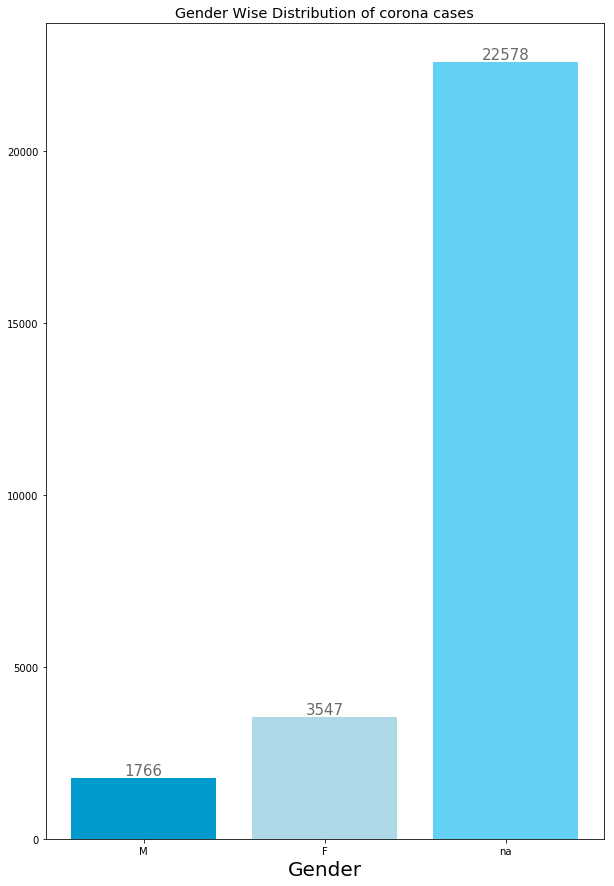

<IPython.core.display.Javascript object>

In [4]:
# Gender wise distribution of corona virus spread
gender_wise_data = (
    data_with_gender_and_age.groupby("Gender")["count"].sum().reset_index()
)

plot_bar_graph(
    np.array(["M", "F", "na"]),
    gender_wise_data["count"][:],
    title="Gender Wise Distribution of corona cases",
    x_label="Gender",
)

>__We see that data is not available for 78.75% of cases. So we cannot deduce much from this distribution.__

/Users/vikaspandey/miniconda2/envs/datascience/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


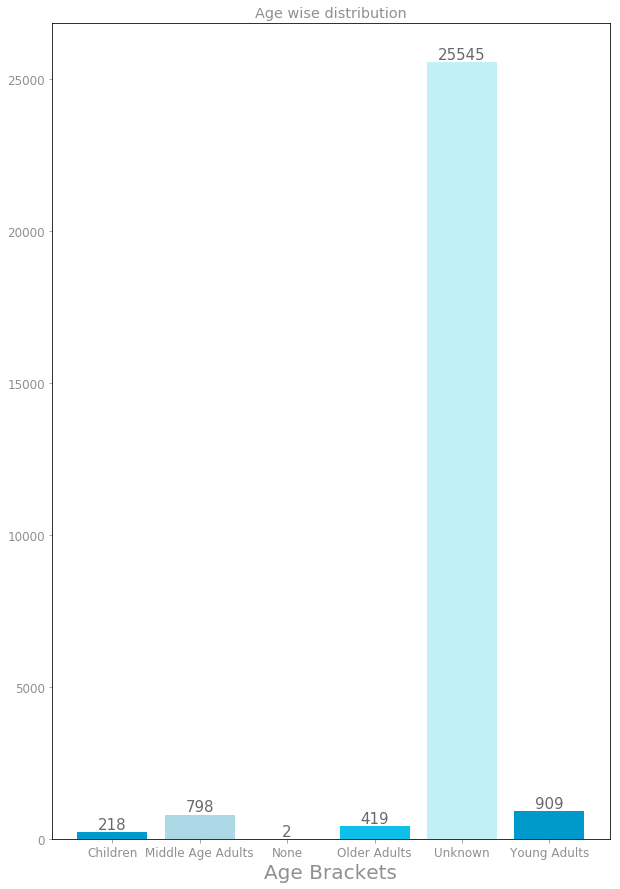

<IPython.core.display.Javascript object>

In [5]:
# Age Bracket wise distribution
def append_age_group(age):
    age_groups = {
        "Children": {"min": 1, "max": 17},
        "Young Adults": {"min": 18, "max": 35},
        "Middle Age Adults": {"min": 36, "max": 55},
        "Older Adults": {"min": 56, "max": 10000000},
    }
    if age == "28-35":
        return "Young Adults"
    if age == "na":
        return "Unknown"
    for key, value in age_groups.items():
        age = float(age)
        if age >= value["min"] and age <= value["max"]:
            return key
    return "None"


data_with_gender_and_age["age_bracket"] = data_with_gender_and_age["Age Bracket"].apply(
    append_age_group
)
age_bracket_wise_data = data_with_gender_and_age.groupby("age_bracket")["age_bracket", "count"].sum().reset_index()
age_bracket_wise_data.head()
plot_bar_graph(age_bracket_wise_data["age_bracket"].unique(), age_bracket_wise_data["count"][:], title="Age wise distribution", x_label="Age Brackets")



> __Here also we have no age info of about 91.56% of infected cases__

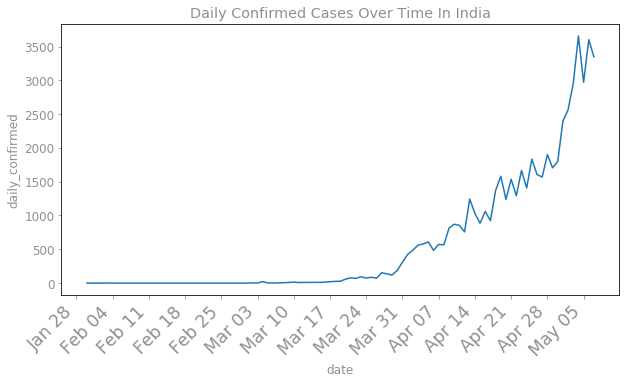

<IPython.core.display.Javascript object>

In [6]:
# Daily Confirmed cases over time
plot_graph(
    case_time_series,
    "Daily Confirmed Cases Over Time In India",
    y_key="daily_confirmed",
)

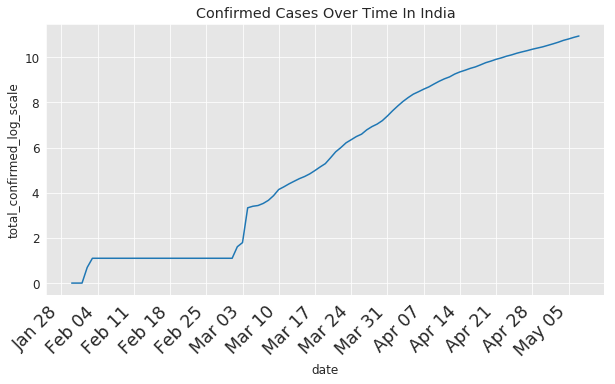

<IPython.core.display.Javascript object>

In [7]:
# Confirmed cases over time.
plot_graph(
    case_time_series,
    "Confirmed Cases Over Time In India",
    y_key="total_confirmed",
    log_scale=True,
)

In [8]:
# Top fast recovering states
state_wise_stats = (
    state_wise_cases[state_wise_cases["state"] != "Total"]
    .groupby(["state"])["confirmed", "recovered", "deaths", "active"]
    .sum()
    .reset_index()
)
state_wise_stats = state_wise_stats[state_wise_stats["confirmed"] > 100]
state_wise_stats["mortality_rate"] = round(
    (state_wise_stats["deaths"] / state_wise_stats["confirmed"]) * 100, 2
)
state_wise_stats["recovery_rate"] = round(
    (state_wise_stats["recovered"] / state_wise_stats["confirmed"]) * 100, 2
)
# Top 20 states with good mortality rate
state_wise_stats.sort_values("mortality_rate", axis=0, ascending=True)[
    :20
].style.background_gradient(cmap="Greens")

,state,confirmed,recovered,deaths,active,mortality_rate,recovery_rate
31,Tamil Nadu,5409,1547,37,3825,0.68,28.6
5,Chandigarh,135,21,1,113,0.74,15.56
17,Kerala,503,474,4,25,0.8,94.23
26,Odisha,245,63,2,180,0.82,25.71
4,Bihar,556,218,5,333,0.9,39.21
9,Delhi,5980,1931,66,3983,1.1,32.29
14,Jammu and Kashmir,793,335,9,449,1.13,42.24
12,Haryana,633,270,8,355,1.26,42.65
28,Punjab,1644,149,28,1467,1.7,9.06
34,Uttar Pradesh,3071,1250,62,1759,2.02,40.7


<IPython.core.display.Javascript object>

>__We see that Mortality rate of kerala is lowest.__

In [9]:
# Top 20 states with good recovery rate
state_wise_stats.sort_values("recovery_rate", axis=0, ascending=False)[
    :20
].style.background_gradient(cmap="Greens")

,state,confirmed,recovered,deaths,active,mortality_rate,recovery_rate
17,Kerala,503,474,4,25,0.8,94.23
32,Telangana,1122,693,29,400,2.58,61.76
29,Rajasthan,3453,1903,100,1450,2.9,55.11
16,Karnataka,750,371,30,348,4,49.47
1,Andhra Pradesh,1887,842,41,1004,2.17,44.62
12,Haryana,633,270,8,355,1.26,42.65
14,Jammu and Kashmir,793,335,9,449,1.13,42.24
34,Uttar Pradesh,3071,1250,62,1759,2.02,40.7
4,Bihar,556,218,5,333,0.9,39.21
20,Madhya Pradesh,3252,1231,193,1828,5.93,37.85


<IPython.core.display.Javascript object>

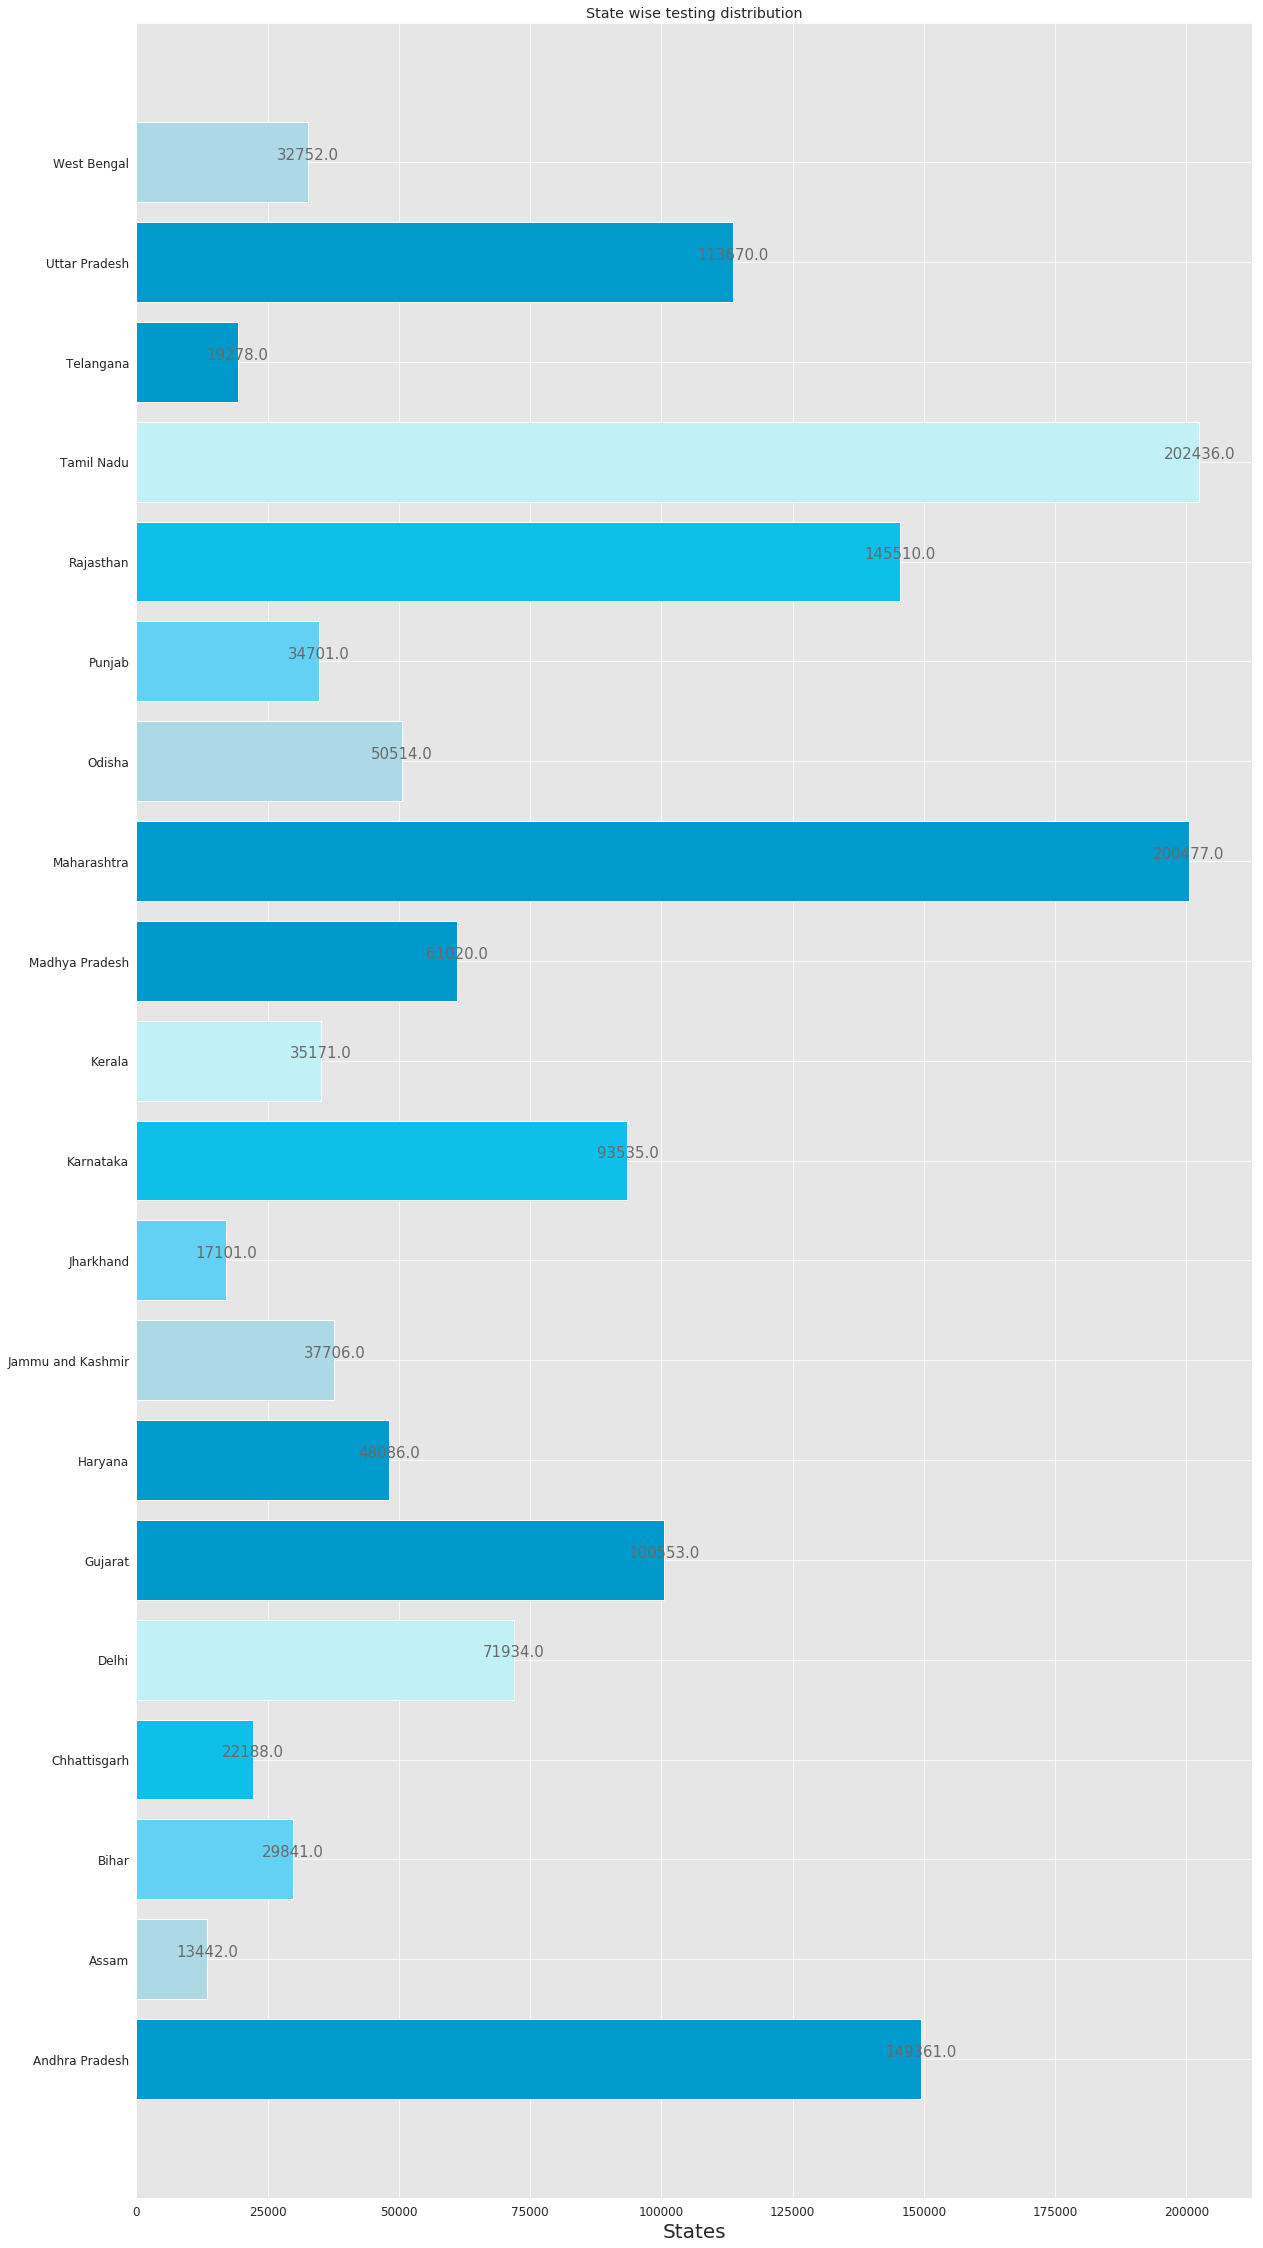

<IPython.core.display.Javascript object>

In [10]:
state_wise_testing_data = state_wise_tested_numbers[
    ["state", "date_1", "total_tested", "positive", "negative", "unconfirmed"]
]
state_wise_testing_data = state_wise_testing_data[
    state_wise_testing_data["total_tested"] > 10000
]
state_wise_testing_data_agg = (
    state_wise_testing_data.groupby(["state"])[
        "date_1", "total_tested", "positive", "negative"
    ]
    .last()
    .reset_index()
)
# statewise testing numbers.
plot_bar_graph(
    state_wise_testing_data_agg["state"].unique(),
    state_wise_testing_data_agg["total_tested"][:],
    title="State wise testing distribution",
    x_label="States",
    horizontal=True,
    show_percentage=False,
    fig_size=(20, 40),
)

In [22]:
tested_numbers_icmr_data = dfs["tested_numbers_icmr_data"][
    ["date_1", "samples_tested", "individuals_tested"]
]
tested_numbers_icmr_data["date"] = tested_numbers_icmr_data["date_1"].dt.strftime(
    "%Y-%m-%d"
)
tested_numbers_icmr_data["date"] = pd.to_datetime(tested_numbers_icmr_data["date"])
case_time_series_truncated = case_time_series[["date", "daily_confirmed"]]
case_time_series_truncated["date"] = pd.to_datetime(case_time_series["date"])
tested_numbers_icmr_data = tested_numbers_icmr_data[
    tested_numbers_icmr_data["date"] >= "2020-03-13"
]
result = (
    pd.merge(
        tested_numbers_icmr_data, case_time_series_truncated, how="inner", on="date"
    )
    .groupby("date")["daily_confirmed", "samples_tested"]
    .max()
    .reset_index()
)
result["date"] = pd.to_datetime(result["date"])
result["daily_tested_numbers"] = result.sort_values("date", ascending=True)[
    "samples_tested"
].diff()

result = result.sort_values("date", axis=0, ascending=True)
result
# testing over time
#plot_graph(result, "Testing Over time", y_key="samples_tested")


,date_1,samples_tested,individuals_tested,date
0,2020-03-13 00:00:00,6500.0,5900.0,2020-03-13
1,2020-03-18 18:00:00,13125.0,12235.0,2020-03-18
2,2020-03-19 10:00:00,13316.0,12426.0,2020-03-19
3,2020-03-19 18:00:00,14175.0,13285.0,2020-03-19
4,2020-03-20 10:00:00,14376.0,13486.0,2020-03-20
5,2020-03-20 18:00:00,15404.0,14514.0,2020-03-20
6,2020-03-21 10:00:00,15701.0,14811.0,2020-03-21
7,2020-03-21 18:00:00,16911.0,16021.0,2020-03-21
8,2020-03-22 10:00:00,16999.0,16109.0,2020-03-22
9,2020-03-22 18:00:00,18127.0,17237.0,2020-03-22


<IPython.core.display.Javascript object>

### India COVID-19 Forecasting

#### Sigmoid Model

107662.41480179621 0.09776652918482352 97.78404769687846


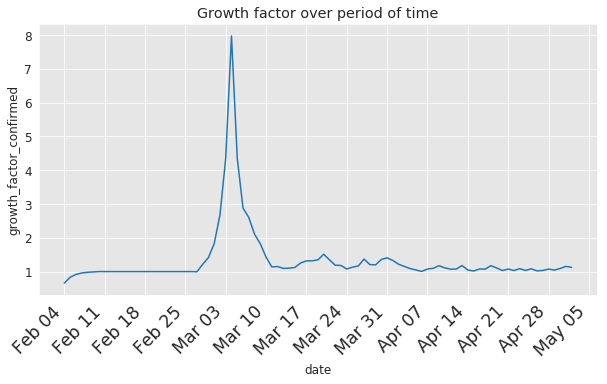

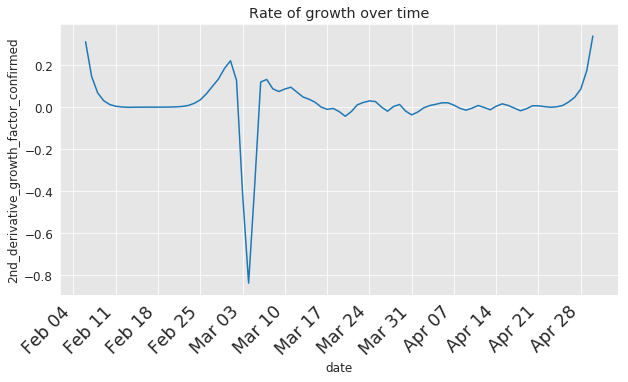

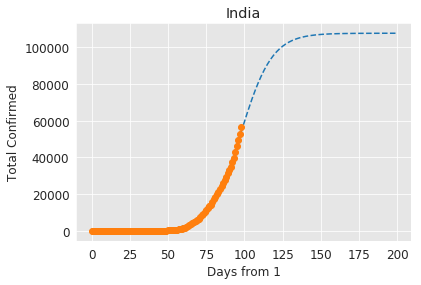

<IPython.core.display.Javascript object>

In [13]:
# forecasting the number of confirmed cases
case_time_series_grouped = (
    case_time_series.groupby("date")["total_confirmed", "total_deceased"]
    .sum()
    .reset_index()
)

case_time_series_grouped["growth_factor_confirmed"] = growth_factor(
    case_time_series_grouped["total_confirmed"]
)

case_time_series_grouped["growth_factor_confirmed"] = smoother(
    case_time_series_grouped["growth_factor_confirmed"], 0.5, 5
)

case_time_series_grouped["2nd_derivative_growth_factor_confirmed"] = np.gradient(
    np.gradient(case_time_series_grouped["growth_factor_confirmed"])
)

case_time_series_grouped["2nd_derivative_growth_factor_confirmed"] = smoother(
    case_time_series_grouped["2nd_derivative_growth_factor_confirmed"], 0.5, 7
)

plot_graph(
    case_time_series_grouped,
    "Growth factor over period of time",
    y_key="growth_factor_confirmed",
)

plot_graph(
    case_time_series_grouped,
    "Rate of growth over time",
    y_key="2nd_derivative_growth_factor_confirmed",
)

estimated_k, estimated_x_0, ymax = fit(case_time_series_grouped, "total_confirmed")

plot_fitted_data(
    estimated_k,
    estimated_x_0,
    ymax,
    case_time_series_grouped,
    "total_confirmed",
    xlabel="Days from 1",
    ylabel="Total Confirmed",
    title="India",
)

print(estimated_k, estimated_x_0, ymax)

#### 1. Max number of predicted confirmed cases: 48398
#### 2. model sigmoidal coefficient is: 0.12
#### 3. model curve stop steepening, start flattening by day: 84 which is 22nd Apr
#### 4. model curve flattens by day: 160 i.e 7th july

4328.225147413176 0.09530075273812798 101.01133824557327


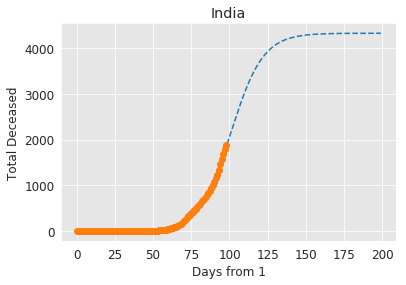

<IPython.core.display.Javascript object>

In [14]:
# Forecasting the number of deaths
estimated_k, estimated_x_0, ymax = fit(case_time_series_grouped, "total_deceased")
print(estimated_k, estimated_x_0, ymax)
plot_fitted_data(
    estimated_k,
    estimated_x_0,
    ymax,
    case_time_series_grouped,
    "total_deceased",
    xlabel="Days from 1",
    ylabel="Total Deceased",
    title="India",
)


#### 1. Max number of predicted deaths: 1428
#### 2. model sigmoidal coefficient is: 0.13
#### 3. model curve stop steepening, start flattening by day: 84 which is 21nd Apr
#### 4. model curve flattens by day: 160 i.e 7th july